In [64]:
import logging
import grpc
import time
import numpy as np
import pandas as pd
import server_tools_pb2
import server_tools_pb2_grpc
from google.protobuf import empty_pb2
from matplotlib import pyplot as plt

PORT = '50051'

def run_facile(channel, data_send, num_data_send, batch_size):
    start_time = time.time()
    # Get a client ID which you need to talk to the server
    stub = server_tools_pb2_grpc.FacileServerStub(channel)
    try:
        #logging.info("Request client id from server")
        response = stub.RequestClientID(server_tools_pb2.NullParam())
    except BaseException:
        print(
             """Connection to the server could not be established.
             Press enter to try again.""")
        return
    client_id = response.new_id
    #logging.info("Client id is " + str(client_id))
    finish_time = time.time()-start_time

    #print("Time establishing server connections ", finish_time)
    # Send the data to the server and receive an answer
    start_time = time.time()
    #logging.info("Number tested is " + str(num_data_send))
    #logging.info("Submitting files and waiting")
    data_message = server_tools_pb2.DataMessage(
        client_id=client_id, data=data_send, batch_size=batch_size)
    response = stub.StartJobWait(data_message, 100, [])

    # Print output
    whole_time = time.time() - start_time
    #print("Whole time:", whole_time)
    #print("Predict time:", response.infer_time)
    #print("Fraction of time spent not predicting:",
    #      (1 - response.infer_time / whole_time) * 100, '%')
    A = np.frombuffer(response.prediction,dtype = np.float32)
    print(list(np.frombuffer(response.prediction,dtype = np.float32))[:10])
    infer_time_GPU = response.infer_time_GPU
    infer_time_CPU = response.infer_time_CPU
    channel.close()
    return infer_time_GPU, infer_time_CPU


def setup_server(host_IP):
    start_time = time.time()
    options = [('grpc.max_receive_message_length', 500*1024*1024 )]
    channel = grpc.insecure_channel(host_IP + ':' + PORT, options = options)
    
    finish_time = time.time()-start_time
    #print("Time defining server stub is ", finish_time)
    return channel

In [65]:
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)
logging.basicConfig(level=logging.NOTSET)

start_time = time.time()
read_rec_hit = pd.read_pickle("input/X_HB.pkl")
read_rec_hit.drop(['PU', 'pt'], 1, inplace=True)
mu,std = np.mean(read_rec_hit, axis=0), np.std(read_rec_hit, axis=0)
print("mu is ", mu)
print("std is ", std)
read_rec_hit = (read_rec_hit-mu)/std


mu is  depth        2.243405
ieta         0.019543
iphi        36.519157
gain         0.000566
raw[0]     136.718005
raw[1]     163.566998
raw[2]     168.755297
raw[3]    4950.089370
raw[4]    2451.871581
raw[5]     808.803050
raw[6]     396.590292
raw[7]     266.167670
dtype: float64
std is  depth         1.045898
ieta          9.394450
iphi         20.708740
gain          0.000184
raw[0]      279.127180
raw[1]      331.065586
raw[2]      335.563759
raw[3]    14553.435515
raw[4]     6339.333508
raw[5]     1654.968567
raw[6]      644.929979
raw[7]      382.568971
dtype: float64


In [70]:
IP = "localhost"
num_send = 16000
read_rec_hit_sliced = read_rec_hit[:num_send]
print(len(read_rec_hit))
finish_time = time.time()-start_time
print("Time reading data from local file and preprocessing (pkl->pandas) is ", finish_time)

start_time = time.time()
compressed_data = read_rec_hit_sliced.to_json().encode('utf-8')
finish_time = time.time()-start_time
print("Time reading data from local file (pandas->bytes) is ", finish_time)

gpu_infer_time = []
cpu_infer_time = []
batch_size_exp = np.arange(8,16)
for i in 2**batch_size_exp:
    gpu_time, cpu_time = run_facile(setup_server(IP), compressed_data, num_send, i)
    gpu_infer_time.append(gpu_time)
    cpu_infer_time.append(cpu_time)

574212
Time reading data from local file and preprocessing (pkl->pandas) is  114.32155919075012
Time reading data from local file (pandas->bytes) is  0.03364968299865723
[0.47296926, 1.2152032, 40.495094, 2.3111198, 16.47494, 0.45779997, 3.7823992, 48.71367, 10.603151, 0.64615643]
[0.47296926, 1.2152032, 40.495094, 2.3111198, 16.47494, 0.45779997, 3.7823992, 48.71367, 10.603151, 0.64615643]
[0.47296926, 1.2152032, 40.495094, 2.3111198, 16.47494, 0.45779997, 3.7823992, 48.71367, 10.603151, 0.64615643]
[0.47296926, 1.2152032, 40.495094, 2.3111198, 16.47494, 0.45779997, 3.7823992, 48.71367, 10.603151, 0.64615643]
[0.47296926, 1.2152032, 40.495094, 2.3111198, 16.47494, 0.45779997, 3.7823992, 48.71367, 10.603151, 0.64615643]
[0.47296926, 1.2152032, 40.495094, 2.3111198, 16.47494, 0.45779997, 3.7823992, 48.71367, 10.603151, 0.64615643]
[0.47296926, 1.2152032, 40.495094, 2.3111198, 16.47494, 0.45779997, 3.7823992, 48.71367, 10.603151, 0.64615643]
[0.47296926, 1.2152032, 40.495094, 2.3111198, 

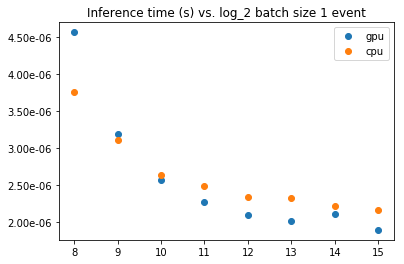

In [71]:
N = 16000
mpl_logger = logging.getLogger("matplotlib")
mpl_logger.setLevel(logging.WARNING)

import matplotlib.ticker as mtick

fig = plt.figure()

ax = fig.add_subplot(111)
ax.plot(np.array(batch_size_exp), np.array(gpu_infer_time)/num_send, 'o', label = 'gpu')
ax.plot(np.array(batch_size_exp), np.array(cpu_infer_time)/num_send, 'o', label = 'cpu')
ax.legend()
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.title("Inference time (s) vs. log_2 batch size " + str(int(num_send/N)) + " event")
plt.show()

In [74]:
IP = "localhost"
num_send = 160000
read_rec_hit_sliced = read_rec_hit[:num_send]
print(len(read_rec_hit))
finish_time = time.time()-start_time
print("Time reading data from local file and preprocessing (pkl->pandas) is ", finish_time)

start_time = time.time()
compressed_data = read_rec_hit_sliced.to_json().encode('utf-8')
finish_time = time.time()-start_time
print("Time reading data from local file (pandas->bytes) is ", finish_time)

gpu_infer_time = []
cpu_infer_time = []

batch_size_exp = np.arange(10,18)
for i in 2**batch_size_exp:
    gpu_time, cpu_time = run_facile(setup_server(IP), compressed_data, num_send, i)
    gpu_infer_time.append(gpu_time)
    cpu_infer_time.append(cpu_time)

574212
Time reading data from local file and preprocessing (pkl->pandas) is  54.58152198791504
Time reading data from local file (pandas->bytes) is  0.34763646125793457
[0.47296926, 1.2152032, 40.495094, 2.3111198, 16.47494, 0.45779997, 1.0003414, 0.3947206, 48.80128, 1.6885962]
[0.47296926, 1.2152032, 40.495094, 2.3111198, 16.47494, 0.45779997, 1.0003414, 0.3947206, 48.80128, 1.6885962]
[0.47296926, 1.2152032, 40.495094, 2.3111198, 16.47494, 0.45779997, 1.0003414, 0.3947206, 48.80128, 1.6885962]
[0.47296926, 1.2152032, 40.495094, 2.3111198, 16.47494, 0.45779997, 1.0003414, 0.3947206, 48.80128, 1.6885962]
[0.47296926, 1.2152032, 40.495094, 2.3111198, 16.47494, 0.45779997, 1.0003414, 0.3947206, 48.80128, 1.6885962]
[0.47296926, 1.2152032, 40.495094, 2.3111198, 16.47494, 0.45779997, 1.0003414, 0.3947206, 48.80128, 1.6885962]
[0.47296926, 1.2152032, 40.495094, 2.3111198, 16.47494, 0.45779997, 1.0003414, 0.3947206, 48.80128, 1.6885962]
[0.47296926, 1.2152032, 40.495094, 2.3111198, 16.47494

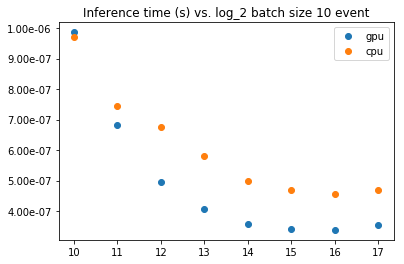

In [75]:
N = 16000
mpl_logger = logging.getLogger("matplotlib")
mpl_logger.setLevel(logging.WARNING)

import matplotlib.ticker as mtick

fig = plt.figure()

ax = fig.add_subplot(111)
ax.plot(np.array(batch_size_exp), np.array(gpu_infer_time)/num_send, 'o', label = 'gpu')
ax.plot(np.array(batch_size_exp), np.array(cpu_infer_time)/num_send, 'o', label = 'cpu')
ax.legend()

ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.title("Inference time (s) vs. log_2 batch size " + str(int(num_send/N)) + " event")
plt.show()

In [55]:
IP = "localhost"
num_send = 640000
read_rec_hit_sliced = read_rec_hit[:num_send]
print(len(read_rec_hit))
finish_time = time.time()-start_time
print("Time reading data from local file and preprocessing (pkl->pandas) is ", finish_time)

start_time = time.time()
compressed_data = read_rec_hit_sliced.to_json().encode('utf-8')
finish_time = time.time()-start_time
print("Time reading data from local file (pandas->bytes) is ", finish_time)

gpu_infer_time = []
cpu_infer_time = []


batch_size_exp = np.arange(10,25)
for i in 2**batch_size_exp:
    gpu_time, cpu_time = run_facile(setup_server(IP), compressed_data, num_send, i)
    gpu_infer_time.append(gpu_time)
    cpu_infer_time.append(cpu_time)
print(gpu_infer_time)
print(cpu_infer_time)

574212
Time reading data from local file and preprocessing (pkl->pandas) is  127.7636468410492
Time reading data from local file (pandas->bytes) is  1.2381255626678467
[0.47296926, 1.2152032, 40.495094, 2.3111198, 16.47494, 0.45779997, 1.0003414, 0.3947206, 48.80128, 1.6885962]
[0.47296926, 1.2152032, 40.495094, 2.3111198, 16.47494, 0.45779997, 1.0003414, 0.3947206, 48.80128, 1.6885962]
[0.47296926, 1.2152032, 40.495094, 2.3111198, 16.47494, 0.45779997, 1.0003414, 0.3947206, 48.80128, 1.6885962]
[0.47296926, 1.2152032, 40.495094, 2.3111198, 16.47494, 0.45779997, 1.0003414, 0.3947206, 48.80128, 1.6885962]
[0.47296926, 1.2152032, 40.495094, 2.3111198, 16.47494, 0.45779997, 1.0003414, 0.3947206, 48.80128, 1.6885962]
[0.47296926, 1.2152032, 40.495094, 2.3111198, 16.47494, 0.45779997, 1.0003414, 0.3947206, 48.80128, 1.6885962]
[0.47296926, 1.2152032, 40.495094, 2.3111198, 16.47494, 0.45779997, 1.0003414, 0.3947206, 48.80128, 1.6885962]
[0.47296926, 1.2152032, 40.495094, 2.3111198, 16.47494,

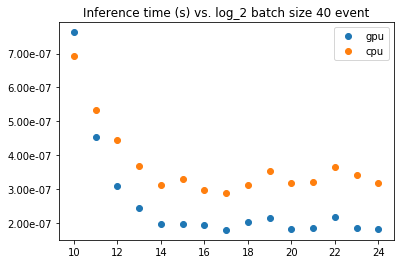

In [56]:
N = 16000
mpl_logger = logging.getLogger("matplotlib")
mpl_logger.setLevel(logging.WARNING)

import matplotlib.ticker as mtick

fig = plt.figure()

ax = fig.add_subplot(111)

ax.plot(np.array(batch_size_exp), np.array(gpu_infer_time)/num_send, 'o', label = 'gpu')
ax.plot(np.array(batch_size_exp), np.array(cpu_infer_time)/num_send, 'o', label = 'cpu')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax.legend()
plt.title("Inference time (s) vs. log_2 batch size " + str(int(num_send/N)) + " event")
plt.show()